<a href="https://colab.research.google.com/github/muriloasouza/Deep-Learning/blob/master/Github_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install tensorflow 2.x in Colab

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
  
# Import libraries  
from __future__ import absolute_import, division, print_function, unicode_literals

#Power data classification/regression with CNN
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import time as time
import matplotlib.pyplot as plt
import pydot
import csv as csv
import keras.backend as K
import itertools
%matplotlib inline
print("TensorFlow version:",tf.__version__)

TensorFlow 2.x selected.
TensorFlow version: 2.1.0-rc1


Using TensorFlow backend.


In [2]:
# Downloading data files 
!wget https://raw.githubusercontent.com/muriloasouza/Deep-Learning/master/Input.txt
!wget https://raw.githubusercontent.com/muriloasouza/Deep-Learning/master/Labels.txt
!wget https://raw.githubusercontent.com/muriloasouza/Deep-Learning/master/Input_Train.txt
!wget https://raw.githubusercontent.com/muriloasouza/Deep-Learning/master/Labels_Train.txt
!wget https://raw.githubusercontent.com/muriloasouza/Deep-Learning/master/Input_Valid.txt
!wget https://raw.githubusercontent.com/muriloasouza/Deep-Learning/master/Labels_Valid.txt
  
def data_set_size(csv_file):
    with open(csv_file) as csvfile:
        csv_rows = 0
        for _ in csvfile:
            csv_rows += 1
    return csv_rows-1            #Remove header from count and return

labels = "./Labels.txt"
labels_train = "./Labels_Train.txt"
labels_valid = "./Labels_Valid.txt"
total = data_set_size(labels)
total_train = data_set_size(labels_train)
total_valid = data_set_size(labels_valid)
print("Total Samples:",total)
print("Total Training Samples:",total_train)
print("Total Validation Samples:",total_valid)

--2020-01-09 11:22:34--  https://raw.githubusercontent.com/muriloasouza/Deep-Learning/master/Input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892480 (872K) [text/plain]
Saving to: ‘Input.txt.2’

Input.txt.2         100%[===================>] 871.56K  --.-KB/s    in 0.02s   

2020-01-09 11:22:34 (56.6 MB/s) - ‘Input.txt.2’ saved [892480/892480]

--2020-01-09 11:22:39--  https://raw.githubusercontent.com/muriloasouza/Deep-Learning/master/Labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86669 (85K) [text/plain]
Saving to: ‘L

In [0]:
#Python generator to supply batches of traning data during training with loading full data set to memory
def power_data_generator(batch_size,gen_type=''):
    while 1:
        df_input_train=pd.read_csv('./Input_Train.txt',usecols =['Wind_MWh','Actual_Load_MWh'],chunksize = 24*batch_size, iterator=True)
        df_target_train=pd.read_csv('./Labels_Train.txt',usecols =['Potencia_Media_do_Vento_(MW)','Desvio_Padrao_Vento_(MW)','FCSPV_(Fracao_de_Carga_Suprida_pela_Potencia_do_Vento)'],chunksize = batch_size, iterator=True)
        df_input_valid=pd.read_csv('./Input_Valid.txt',usecols =['Wind_MWh','Actual_Load_MWh'],chunksize = 24*batch_size, iterator=True)
        df_target_valid=pd.read_csv('./Labels_Valid.txt',usecols =['Potencia_Media_do_Vento_(MW)','Desvio_Padrao_Vento_(MW)','FCSPV_(Fracao_de_Carga_Suprida_pela_Potencia_do_Vento)'],chunksize = batch_size, iterator=True)
        for chunk, chunk2, chunk3, chunk4 in zip(df_input_train,df_target_train,df_input_valid,df_target_valid):
          X_train = chunk.values
          X_train = np.resize(X_train,(batch_size,24,2,1))
          Y_train = chunk2.values
          X_valid = chunk3.values
          X_valid = np.resize(X_valid,(batch_size,24,2,1))
          Y_valid = chunk4.values
          if len(Y_train) < batch_size:
            X_train = X_train[:-batch_size*len(Y_valid)]
            Y_train = Y_train[:-len(Y_valid)]
          if len(Y_valid) < batch_size:
            X_valid = X_valid[:-batch_size*len(Y_valid)]
            Y_valid = Y_valid[:-len(Y_valid)]       
          if gen_type =='training':
            yield (X_train[0:batch_size],Y_train[0:batch_size])
          elif gen_type =='validation':
            yield (X_valid[0:batch_size],Y_valid[0:batch_size])
          elif gen_type =='inference':
            yield X_valid

In [0]:
# Custom Metric

def nossa_metrica(y_true, y_pred): # Overall metric
  truepotventolow = K.cast(K.less_equal(y_true[:,0], 4000), 'int8')
  predpotventolow = K.cast(K.less_equal(y_pred[:,0], 4000), 'int8')
  potventolow = K.sum(truepotventolow*predpotventolow)
  truepotventomed = K.cast(K.greater(y_true[:,0], 4000) & K.less_equal(y_true[:,0], 8500), 'int8')
  predpotventomed = K.cast(K.greater(y_pred[:,0], 4000) & K.less_equal(y_pred[:,0], 8500), 'int8')
  potventomed = K.sum(truepotventomed*predpotventomed)
  truepotventohigh = K.cast(K.greater(y_true[:,0], 8500), 'int8')
  predpotventohigh = K.cast(K.greater(y_pred[:,0], 8500), 'int8')
  potventohigh = K.sum(truepotventohigh*predpotventohigh)
  truedesvpadlow = K.cast(K.less_equal(y_true[:,1], 1150), 'int8')
  preddesvpadlow = K.cast(K.less_equal(y_pred[:,1], 1150), 'int8')
  desvpadlow = K.sum(truedesvpadlow*preddesvpadlow)
  truedesvpadmed = K.cast(K.greater(y_true[:,1], 1150) & K.less_equal(y_true[:,1], 2300), 'int8')
  preddesvpadmed = K.cast(K.greater(y_pred[:,1], 1150) & K.less_equal(y_pred[:,1], 2300), 'int8')
  desvpadmed = K.sum(truedesvpadmed*preddesvpadmed)
  truedesvpadhigh = K.cast(K.greater(y_true[:,1], 2300), 'int8')
  preddesvpadhigh = K.cast(K.greater(y_pred[:,1], 2300), 'int8')
  desvpadhigh = K.sum(truedesvpadhigh*preddesvpadhigh)
  truewlslow = K.cast(K.less_equal(y_true[:,2], 0.075), 'int8')
  predwlslow = K.cast(K.less_equal(y_pred[:,2], 0.075), 'int8')
  wlslow = K.sum(truewlslow*predwlslow)   
  truewlshigh = K.cast(K.greater(y_true[:,2], 0.075), 'int8')
  predwlshigh = K.cast(K.greater(y_pred[:,2], 0.075), 'int8')
  wlshigh = K.sum(truewlshigh*predwlshigh)
  return (potventolow+potventomed+potventohigh+desvpadlow+desvpadmed+desvpadhigh+wlslow+wlshigh)/(Yclasses*batch_size)

def potvento(y_true, y_pred): # Metric for first class
  truepotventolow = K.cast(K.less_equal(y_true[:,0], 4000), 'int8')
  predpotventolow = K.cast(K.less_equal(y_pred[:,0], 4000), 'int8')
  potventolow = K.sum(truepotventolow*predpotventolow)
  truepotventomed = K.cast(K.greater(y_true[:,0], 4000) & K.less_equal(y_true[:,0], 8500), 'int8')
  predpotventomed = K.cast(K.greater(y_pred[:,0], 4000) & K.less_equal(y_pred[:,0], 8500), 'int8')
  potventomed = K.sum(truepotventomed*predpotventomed)
  truepotventohigh = K.cast(K.greater(y_true[:,0], 8500), 'int8')
  predpotventohigh = K.cast(K.greater(y_pred[:,0], 8500), 'int8')
  potventohigh = K.sum(truepotventohigh*predpotventohigh)
  return (potventolow+potventomed+potventohigh)/(batch_size)

def desvpad(y_true, y_pred): # Metric for second class
  truedesvpadlow = K.cast(K.less_equal(y_true[:,1], 1150), 'int8')
  preddesvpadlow = K.cast(K.less_equal(y_pred[:,1], 1150), 'int8')
  desvpadlow = K.sum(truedesvpadlow*preddesvpadlow)
  truedesvpadmed = K.cast(K.greater(y_true[:,1], 1150) & K.less_equal(y_true[:,1], 2300), 'int8')
  preddesvpadmed = K.cast(K.greater(y_pred[:,1], 1150) & K.less_equal(y_pred[:,1], 2300), 'int8')
  desvpadmed = K.sum(truedesvpadmed*preddesvpadmed)
  truedesvpadhigh = K.cast(K.greater(y_true[:,1], 2300), 'int8')
  preddesvpadhigh = K.cast(K.greater(y_pred[:,1], 2300), 'int8')
  desvpadhigh = K.sum(truedesvpadhigh*preddesvpadhigh)    
  return (desvpadlow+desvpadmed+desvpadhigh)/(batch_size)

def wls(y_true, y_pred): # Metric for third class
  truewlslow = K.cast(K.less_equal(y_true[:,2], 0.075), 'int8')
  predwlslow = K.cast(K.less_equal(y_pred[:,2], 0.075), 'int8')
  wlslow = K.sum(truewlslow*predwlslow)   
  truewlshigh = K.cast(K.greater(y_true[:,2], 0.075), 'int8')
  predwlshigh = K.cast(K.greater(y_pred[:,2], 0.075), 'int8')
  wlshigh = K.sum(truewlshigh*predwlshigh)  
  return (wlslow+wlshigh)/(batch_size)

In [5]:
#Define model using Keras

batch_size = 16
Yclasses = 3 # Number of output classes
bias0 =  'zeros'
kernel0 = 'glorot_uniform'
#dropout = 0.1


model = keras.Sequential([
    tf.keras.layers.Input(shape=(24,2,1),name='InputLayer'),                    
    tf.keras.layers.Conv2D(filters=4,kernel_size=(6,2),strides=(1,1),activation='relu',bias_initializer=bias0,kernel_initializer=kernel0,name='ConvLayer1'),
    #tf.keras.layers.Dropout(rate=dropout),
    tf.keras.layers.Conv2D(filters=4,kernel_size=(6,1),strides=(1,1),activation='relu',bias_initializer=bias0,kernel_initializer=kernel0,name='ConvLayer2'),
    #tf.keras.layers.Dropout(rate=dropout),
    tf.keras.layers.Flatten(name="Flatten"),
    tf.keras.layers.Dense(units = 8,activation='relu',bias_initializer=bias0,kernel_initializer=kernel0,name='FeedForward1'),
    #tf.keras.layers.Dropout(rate=dropout),
    tf.keras.layers.Dense(units = 8,activation='relu',bias_initializer=bias0,kernel_initializer=kernel0,name='FeedForward2'),
    #tf.keras.layers.Dropout(rate=dropout),
    tf.keras.layers.Dense(units = 8,activation='relu',bias_initializer=bias0,kernel_initializer=kernel0,name='FeedForward3'),
    #tf.keras.layers.Dropout(rate=dropout),
    tf.keras.layers.Dense(units = 8,activation='relu',bias_initializer=bias0,kernel_initializer=kernel0,name='FeedForward4'),
    #tf.keras.layers.Dropout(rate=dropout),
    tf.keras.layers.Dense(units = Yclasses,bias_initializer=bias0,kernel_initializer=kernel0,name='OutputLayer'),
])
model.compile(loss='mse',optimizer='adam',metrics=[nossa_metrica,potvento,desvpad,wls])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvLayer1 (Conv2D)          (None, 19, 1, 4)          52        
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 14, 1, 4)          100       
_________________________________________________________________
Flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
FeedForward1 (Dense)         (None, 8)                 456       
_________________________________________________________________
FeedForward2 (Dense)         (None, 8)                 72        
_________________________________________________________________
FeedForward3 (Dense)         (None, 8)                 72        
_________________________________________________________________
FeedForward4 (Dense)         (None, 8)                 7

In [6]:
train_generator= power_data_generator(batch_size=batch_size,gen_type='training')
valid_generator= power_data_generator(batch_size=batch_size,gen_type='validation')
number_of_training_batches = np.int32(total_train/batch_size)
number_of_validation_batches = np.int32(total_valid/batch_size) 
#Training starts
t = time.time()
history = model.fit_generator(train_generator, steps_per_epoch= number_of_training_batches,epochs=100,validation_data=valid_generator, validation_steps=number_of_validation_batches,verbose=2)
print("Loss de treinamento minima:",min(history.history["loss"]))
print("Acuracia de treinamento maxima:",max(history.history["nossa_metrica"]))
print("Loss de valdiacao minima:",min(history.history["val_loss"]))
print("Acuracia de validacao maxima:",max(history.history["val_nossa_metrica"])) 
print("Time: %.3f minutes" % ((time.time() - t)/60))
model.save('model.h5')
print("Model Saved")

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 57 steps, validate for 14 steps
Epoch 1/100
57/57 - 4s - loss: 7050502.9649 - nossa_metrica: 0.5252 - potvento: 0.5296 - desvpad: 0.5877 - wls: 0.4583 - val_loss: 13243703.9643 - val_nossa_metrica: 0.4137 - val_potvento: 0.3214 - val_desvpad: 0.4241 - val_wls: 0.4955
Epoch 2/100
57/57 - 1s - loss: 2628384.4529 - nossa_metrica: 0.4890 - potvento: 0.5241 - desvpad: 0.4967 - wls: 0.4463 - val_loss: 2897971.9375 - val_nossa_metrica: 0.4554 - val_potvento: 0.4464 - val_desvpad: 0.4330 - val_wls: 0.4866
Epoch 3/100
57/57 - 1s - loss: 1342972.7741 - nossa_metrica: 0.5395 - potvento: 0.6118 - desvpad: 0.5614 - wls: 0.4452 - val_loss: 2822389.8036 - val_nossa_metrica: 0.4301 - val_potvento: 0.4330 - val_desvpad: 0.4018 - val_wls: 0.4554
Epoch 4/100
57/57 - 1s - loss: 1198286.5482 - nossa_metrica: 0.5435 - potvento: 0.6930 - desvpad: 0.5779 - wls: 0.3596 - val_l

In [7]:
inference_generator= power_data_generator(batch_size=1,gen_type='inference')  #Generator for getting only input data
test_input = next(inference_generator)  #Get next batch of input data from data set
print(test_input)
out = model.predict_on_batch(test_input)   #Probability predictions for giving input
print(out)

[[[[  3477.64]
   [ 78900.06]]

  [[  3727.94]
   [ 75148.44]]

  [[  3396.8 ]
   [ 72802.24]]

  [[  3273.75]
   [ 71745.32]]

  [[  2800.58]
   [ 72721.22]]

  [[  2346.93]
   [ 75755.16]]

  [[  2030.39]
   [ 79904.28]]

  [[  1509.42]
   [ 84915.09]]

  [[   743.17]
   [ 89481.  ]]

  [[   657.4 ]
   [ 94311.15]]

  [[   935.75]
   [ 98981.73]]

  [[  1121.12]
   [102664.29]]

  [[  1213.22]
   [105564.29]]

  [[  1431.9 ]
   [107830.95]]

  [[  1514.87]
   [109213.87]]

  [[  1719.13]
   [109550.17]]

  [[  1833.03]
   [109127.92]]

  [[  1804.25]
   [107870.04]]

  [[  1379.8 ]
   [105518.03]]

  [[  1177.16]
   [101817.23]]

  [[  1235.9 ]
   [ 99768.25]]

  [[  1482.94]
   [ 95794.2 ]]

  [[  1845.18]
   [ 89056.8 ]]

  [[  2105.73]
   [ 82802.53]]]]
tf.Tensor([[1902.0684    270.20197    13.494536]], shape=(1, 3), dtype=float32)


In [8]:
# Checking accuracy for the givin input of previous code cell

soma = test_input.sum(axis=0).sum(axis=0)
media = np.mean(test_input, axis = (0,1))
desv_pad = np.std(test_input, axis = (0,1))
print("Potência gerada pelo vento = ",media[0])
print("Desvio padrado da potencia do vento = ",desv_pad[0])
wls_true = (soma[0]/24)/(soma[1]/24)
print("Wind Load Share = ", wls_true)
pot_vento_pred = out[-1][0]
desv_pad_pred = out[-1][1]
wls_pred = out[-1][2]
print("Valor predito da potencia gerada pelo vento = ", pot_vento_pred)
print("Valor predito do desvio padrao da potencia do vento = ", desv_pad_pred)
print("Valor predito do Wind Load Share = ", wls_pred)
c = 0
if (media[0] <= 4000 and pot_vento_pred <= 4000) or ((media[0] > 4000 and media[0] <= 8500) and (pot_vento_pred > 4000 and pot_vento_pred <= 8500)) or (media[0] > 8500 and pot_vento_pred > 8500):
  print("Acertou a potencia do vento!")
  c = c+1
else:
  print("Errou a potencia do vento!")
if (desv_pad[0] <= 1150 and desv_pad_pred <= 1150) or ((desv_pad[0] > 1150 and desv_pad[0] <= 2300) and (desv_pad_pred > 1150 and desv_pad_pred <= 2300)) or (desv_pad[0] > 2300 and desv_pad_pred > 2300):
  print("Acertou o desvio padrão da potencia do vento!")
  c = c+1
else:
  print("Errou o desvio padrão da potencia do vento!")
if (wls_true <= 0.075 and wls_pred <= 0.075) or (wls_true > 0.075 and wls_pred > 0.075):
  print("Acertou o Wind Load Share!")
  c = c+1
else:
  print("Errou o Wind Load Share!")
print("Percentual de acerto = ", (c/Yclasses)*100)  

Potência gerada pelo vento =  [1865.16666667]
Desvio padrado da potencia do vento =  [862.8141685]
Wind Load Share =  [0.02015267]
Valor predito da potencia gerada pelo vento =  tf.Tensor(1902.0684, shape=(), dtype=float32)
Valor predito do desvio padrao da potencia do vento =  tf.Tensor(270.20197, shape=(), dtype=float32)
Valor predito do Wind Load Share =  tf.Tensor(13.494536, shape=(), dtype=float32)
Acertou a potencia do vento!
Acertou o desvio padrão da potencia do vento!
Errou o Wind Load Share!
Percentual de acerto =  66.66666666666666


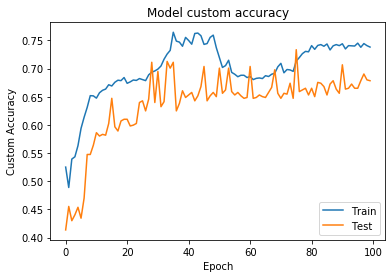

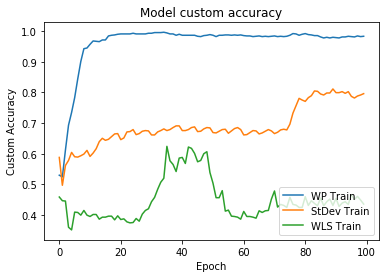

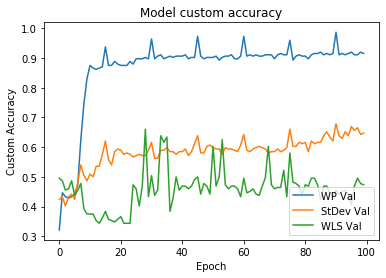

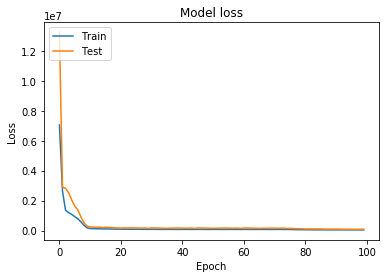

In [9]:
# Ploting

import matplotlib.pyplot as plt

plt.plot(history.history['nossa_metrica'])
plt.plot(history.history['val_nossa_metrica'])
plt.title('Model custom accuracy')
plt.ylabel('Custom Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['potvento'])
plt.plot(history.history['desvpad'])
plt.plot(history.history['wls'])
plt.title('Model custom accuracy')
plt.ylabel('Custom Accuracy')
plt.xlabel('Epoch')
plt.legend(['WP Train','StDev Train','WLS Train'], loc='lower right')
plt.show()

plt.plot(history.history['val_potvento'])
plt.plot(history.history['val_desvpad'])
plt.plot(history.history['val_wls'])
plt.title('Model custom accuracy')
plt.ylabel('Custom Accuracy')
plt.xlabel('Epoch')
plt.legend(['WP Val','StDev Val','WLS Val'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()